In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tqdm import tqdm
from scipy.special import kl_div
import gc
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pandas as pd
from sklearn.utils import shuffle

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../')
from utils import *

# sys.path.append('../SSD/')
# import importlib
# importlib.reload(ssd)
# import ssd as ssd

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
batch_size = 512

# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)
forget_idx = random.sample(list(forget_idx),600)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]
retain_idx = random.sample(list(retain_idx),29400)

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=batch_size, shuffle=False, num_workers=1
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=batch_size, shuffle=False, num_workers=1, generator=RNG
)

In [4]:
def remove_retain_similar_to_forget(feats_retain_df, feats_forget_df, batch_size=64, similarity_metric='cosine', similarity_pct=0.1):
    features_retain = feats_retain_df.iloc[:,1:].values
    features_forget = feats_forget_df.iloc[:,1:].values

    # Compute max similarity
    max_similarity = np.empty(features_retain.shape[0])
    for i in range(0, features_retain.shape[0], 512):
        batch_features_retain = features_retain[i:i+512]
        if similarity_metric=='euclidean':
            similarity_matrix = euclidean_distances(batch_features_retain, features_forget)
            max_similarity[i:i+512] = np.min(similarity_matrix, axis=1)
            top_X_pct_idx = np.argsort(max_similarity)[:int(similarity_pct * len(max_similarity))]
        elif similarity_metric=='cosine':
            similarity_matrix = cosine_similarity(batch_features_retain, features_forget)
            max_similarity[i:i+512] = np.max(similarity_matrix, axis=1)
            top_X_pct_idx = np.argsort(max_similarity)[-int(similarity_pct * len(max_similarity)):]

    # Get X% of data points
    similar_df = feats_retain_df.iloc[top_X_pct_idx]
    similar_ids_set = set(top_X_pct_idx)
    
    include_indices = [i for i,data_id in enumerate(feats_retain_df['unique_id']) if data_id not in similar_ids_set]
    filtered_dataset = Subset(retain_loader.dataset, include_indices)
    
    return DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

In [5]:
def reduce_dataset(
    net, 
    retain_loader, 
    forget_loader,
    similarity_pct
):
    
    '''
    Feature extraction
    '''
    
    feat_extractor = create_feature_extractor(net, {'avgpool': 'feat1'})
    
    '''
    Get class weights
    '''
    
    # Retain logits
    list_of_targets = []
    start_idx = 0
    data = np.empty((len(retain_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in retain_loader:
            # Get logits
            targets = sample[1]
            list_of_targets.append(np.array(targets))
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            image_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [str(person_id[i])+'-'+str(image_id[i])] + feats[i].cpu().numpy().tolist()
                idx +=1
            
    retain_class_weights = torch.tensor(1/np.bincount(np.concatenate(list_of_targets).ravel())).to(DEVICE, dtype=torch.float32)
       
    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    feats_retain_df = pd.DataFrame(data, columns=columns)
    
    # Forget logits
    list_of_targets = []
    start_idx = 0
    data = np.empty((len(forget_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in forget_loader:
            # Get logits
            targets = sample[1]
            list_of_targets.append(np.array(targets))
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            image_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [str(person_id[i])+'-'+str(image_id[i])] + feats[i].cpu().numpy().tolist()
                idx +=1
            
    forget_class_weights = torch.tensor(1/np.bincount(np.concatenate(list_of_targets).ravel())).to(DEVICE, dtype=torch.float32)
       
    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    feats_forget_df = pd.DataFrame(data, columns=columns)
    
    '''
    Reduce retain dataset
    '''
    
    retain_loader = remove_retain_similar_to_forget(feats_retain_df, feats_forget_df, batch_size=retain_loader.batch_size, similarity_metric='euclidean', similarity_pct=similarity_pct)
    
    return retain_class_weights, forget_class_weights, retain_loader

In [6]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs
# weights_pretrained = torch.load("../checkpoints/0.pt", map_location=DEVICE)

# load model with pre-trained weights
net = resnet18(weights=None, num_classes=10)
net.load_state_dict(weights_pretrained)
net.to(DEVICE)
net.eval();

In [7]:
# Reduce retain set and calculate class weights
# retain_class_weights, forget_class_weights, retain_loader = reduce_dataset(net, retain_loader, forget_loader, similarity_pct=0.20)

In [8]:
def calculate_loss(model, inputs, targets):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        loss = torch.nn.CrossEntropyLoss(reduction="none")(outputs, targets)
    return loss.detach().cpu().numpy()

In [9]:
def average_gradient_from_loader(model, optimizer, loader, num_batches):
    last_linear_layer = model.fc
    avg_grad = None
    criterion = nn.CrossEntropyLoss()
    
    count = 0
    for i, (data, target) in enumerate(loader):
        if i >= num_batches:
            break
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        if avg_grad is None:
            avg_grad = last_linear_layer.weight.grad.clone()
        else:
            avg_grad += last_linear_layer.weight.grad.clone()

        count +=1

        return avg_grad / count

# Calculate losses from trained from scratch

In [10]:
original_losses = [[] for _ in range(len(forget_loader.dataset))]

for checkpoint in os.listdir('../unlearn metric/checkpoints/'):

    weights_pretrained = torch.load(f"../unlearn metric/checkpoints/{checkpoint}", map_location=DEVICE)
    try:
        net.load_state_dict(weights_pretrained['net'])
    except:
        net.load_state_dict(weights_pretrained['model_state_dict'])
    net.to(DEVICE)
    net.eval();

    run_losses = []

    for inputs, targets in forget_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        batch_losses = calculate_loss(net, inputs, targets)
        run_losses.extend(batch_losses)

    for idx, loss in enumerate(run_losses):
        original_losses[idx].append(loss)

# Unlearn

In [11]:
# Function to inject noise into the model's weights
def inject_noise(model, noise_level=0.01):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                noise = torch.randn_like(param) * param.abs() * noise_level
                param.add_(noise)
            elif 'bias' in name:
                noise = torch.randn_like(param) * param.abs() * noise_level
                param.add_(noise)

In [12]:
def inject_decay_noise(model, base_noise_level, decay_rate, global_step, min_noise_level=1e-6):
    with torch.no_grad():
        decayed_noise_level = max(base_noise_level * (decay_rate ** global_step), min_noise_level)
        if decayed_noise_level <= min_noise_level:
            return  # Skip noise injection if the level is below the threshold
        for name, param in model.named_parameters():
            if 'weight' in name:
                noise = torch.randn_like(param) * decayed_noise_level * param.abs()
                param.add_(noise)
            elif 'bias' in name:
                noise = torch.randn_like(param) * decayed_noise_level * param.abs()
                param.add_(noise)

In [13]:
def forget(net, forget_loader, optimizer):

    epochs = 1

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    net.train()

    for _ in range(epochs):
        for inputs, targets in forget_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Warm-up for the first 'warmup_batches' batches
            # if current_batch <= warmup_batches:
            #     adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = -1.0*criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)

            optimizer.step()
        # scheduler.step()

In [14]:
def forget_slow(net, forget, initial_lr=0.1, noise_level=0, epochs=1):

    current_batch = 0
    warmup_batches = len(forget)
    global_step = 0

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    net.train()

    if noise_level>0:
        inject_noise(net, noise_level=noise_level)

    for ep in range(epochs):

        # if ep<epochs-2:
        #     inject_noise(net, noise_level=0.20/(ep+1))

        for inputs, targets in forget:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = -1.0*criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()

        # print(accuracy(net, retain_loader))
        # print(accuracy(net, forget_loader))

        scheduler.step()

In [15]:
def retrain_slow(net, retain, initial_lr=0.1, noise_level=0.2, epochs=1, steps_per_epoch=len(retain_loader)):

    current_batch = 0
    warmup_batches = steps_per_epoch
    global_step = 0

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs+1)

    net.train()

    if noise_level>0:
        inject_noise(net, noise_level=noise_level)

    for ep in range(epochs):

        # if ep<epochs-2:
        #     inject_noise(net, noise_level=0.20/(ep+1))

        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()
            global_step += 1

            # if global_step>=steps_per_epoch:
            #     break

        scheduler.step()

In [16]:
def retrain(net, retain, optimizer, steps_per_epoch=len(retain_loader)):

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    steps = 0
    net.train()

    for ep in range(1):

        # if ep<epochs-1:
        #     inject_noise(net, noise_level=0.2/(ep+1))

        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # current_batch += 1

            # # Warm-up for the first 'warmup_batches' batches
            # if current_batch <= warmup_batches:
            #     adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()

            steps+=1

            if steps>=steps_per_epoch:
                break
        # scheduler.step()

In [23]:
def contrastive_unlearning(net, forget_loader, grouped_retain_df, grouped_val_df, LR=1e-3, epochs=3):
    
    custom_model = CustomResNet18(net).to(DEVICE)
    criterion = ContrastiveLoss()
    optimizer = optim.AdamW(custom_model.parameters(), lr=LR)
    
    for ep in range(epochs):
        for i, batch in enumerate(forget_loader):
            custom_model.train()
            optimizer.zero_grad()
            inputs = batch[0].to(DEVICE)
            targets = batch[1]
            person_ids = batch[1]

            # Forward pass to get embeddings for the forget_batch
            forget_embeddings = custom_model(inputs)

            positive_pairs = []
            negative_pairs = []

            with torch.no_grad():  # Disable gradient computation to save memory
                
                # Fetch Positive Pairs
                for index, pid in enumerate(person_ids):
                    candidate_embeddings = grouped_val_df.get(str(pid), None)
                    if candidate_embeddings is not None:  # If a positive pair exists
                        selected_embedding = shuffle(candidate_embeddings, n_samples=1)[0]  # Randomly select one
                    else:  # Fallback to using the instance's own embedding
                        selected_embedding = forget_embeddings[index].cpu().detach().numpy()

                    positive_pairs.append(torch.tensor(selected_embedding.astype(float)).float())


                # Convert to tensors for ease of computation
                positive_pairs = torch.stack(positive_pairs).to(DEVICE)

                # Fetch Negative Pairs
                for tgt in targets.cpu().numpy():
                    candidate_embeddings = grouped_retain_df.get(tgt, None)
                    if candidate_embeddings is not None:
                        selected_embedding = shuffle(candidate_embeddings, n_samples=1)[0]  # Randomly select one
                        negative_pairs.append(torch.tensor(selected_embedding.astype(float)).float())
                    else:
                        break


                # Convert to tensors for ease of computation
                negative_pairs = torch.stack(negative_pairs).to(DEVICE)

            # Compute Contrastive Loss
            positive_loss = criterion(forget_embeddings, positive_pairs, torch.zeros(positive_pairs.shape[0]).to(DEVICE))
            negative_loss = criterion(forget_embeddings, negative_pairs, torch.ones(negative_pairs.shape[0]).to(DEVICE))

            # Total loss
            loss = positive_loss # + negative_loss

            loss.backward()
            optimizer.step()

In [17]:
    # def guided_reset_fc(pct=0.5):
    #     optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    #     num_batches = len(forget_loader.dataset)
    #     grad1 = average_gradient_from_loader(net, optimizer, retain_loader, len(forget_loader.dataset)*1.5)
    #     optimizer.zero_grad()
    #     grad2 = average_gradient_from_loader(net, optimizer, forget_loader, num_batches)
    #     grad_diff = torch.abs(grad1 - grad2)
    #     _, indices = torch.sort(grad_diff, descending=True)
    #     top_x_percent = int(pct * len(indices))
    #     for idx in indices[:top_x_percent]:
    #         for class_idx in range(0,10):
    #             net.fc.weight.data[class_idx, idx] = torch.randn_like(net.fc.weight.data[class_idx, idx])

# Calculate losses from unlearn model

In [18]:
# Clean
gc.collect()
torch.cuda.empty_cache()

In [21]:
'''
Contrastive
'''

weights_pretrained = torch.load(local_path, map_location=DEVICE)
net = resnet18(weights=None, num_classes=10)
net.load_state_dict(weights_pretrained)
net.to(DEVICE)

embeddings_retain_df, embeddings_val_df = get_embeddings(net, retain_loader, val_loader)

# Pre-group embeddings by unique_id for fast lookup
grouped_val_df = embeddings_val_df.groupby('unique_id').apply(lambda x: x.iloc[:, 1:].values)
grouped_retain_df = embeddings_retain_df.groupby('unique_id').apply(lambda x: x.iloc[:, 1:].values)

In [31]:
X = len(os.listdir('../unlearn metric/checkpoints/'))  # number of times to run the unlearning algorithm
unlearn_losses = [[] for _ in range(len(forget_loader.dataset))]  # List of lists to hold losses per sample index
forget_accs = []
test_accs = []

for i in tqdm(range(1)):
    
    # Load original model
    weights_pretrained = torch.load(local_path, map_location=DEVICE)
    net = resnet18(weights=None, num_classes=10)
    net.load_state_dict(weights_pretrained)
    net.to(DEVICE)
    net.train()


    epochs = 1
    contrastive_epochs = 1
    retain_lr = 0.1
    forget_lr = 0.01
    retain_slow_lr = 0.01
    pruning = 0.5
    noise_level = 0.05
    unlearn_steps = 5
    reset_fc = False
    retain_unlear_multiplier = 10


    retain_optimizer = optim.SGD(net.parameters(), lr=retain_lr, momentum=0.9, weight_decay=5e-3)
    retain_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(retain_optimizer, T_max=epochs+1)
    forget_optimizer = optim.SGD(net.parameters(), lr=forget_lr, momentum=0.9, weight_decay=5e-3)
    forget_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(forget_optimizer, T_max=epochs)

    contrastive_unlearning(net, forget_loader, grouped_retain_df, grouped_val_df, LR=forget_lr, epochs=contrastive_epochs)
    retrain(net, retain_loader, retain_optimizer, steps_per_epoch=len(forget_loader)*retain_unlear_multiplier)
    print(f'Forget acc: {accuracy(net, forget_loader)}')
    print(f'Test acc: {accuracy(net, test_loader)}')
    print('............')

    # Unlearn
    unstructure_prune(net, pruning_amount=pruning, global_pruning=True, random_init=False, only_fc=False)
    for _ in range(unlearn_steps):
        forget(net, forget_loader, forget_optimizer)
        print(f'Forget acc: {accuracy(net, forget_loader)}')
        print(f'Test acc: {accuracy(net, test_loader)}')
        print('............')
        retrain(net, retain_loader, retain_optimizer, steps_per_epoch=len(forget_loader)*retain_unlear_multiplier)
        print(f'Forget acc: {accuracy(net, forget_loader)}')
        print(f'Test acc: {accuracy(net, test_loader)}')
        print('-----')

    if reset_fc:
        net.fc.reset_parameters()

    retrain_slow(net, retain_loader, retain_slow_lr, noise_level=noise_level, epochs=epochs)

    
    net.eval()
    run_losses = []

    for inputs, targets in forget_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        batch_losses = calculate_loss(net, inputs, targets)
        run_losses.extend(batch_losses)

    for idx, loss in enumerate(run_losses):
        unlearn_losses[idx].append(loss)

    # Calc metrics
    forget_accs.append(accuracy(net, forget_loader))
    test_accs.append(accuracy(net, test_loader))

    # print(accuracy(net, retain_loader))
    print(f'Forget acc: {forget_accs[-1]}')
    print(f'Test acc: {test_accs[-1]}')

    # Clean
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/1 [00:00<?, ?it/s]

Forget acc: 0.7583333333333333
Test acc: 0.7078
............
Forget acc: 0.7516666666666667
Test acc: 0.7044
............
Forget acc: 0.82
Test acc: 0.7714
-----
Forget acc: 0.7816666666666666
Test acc: 0.7584
............
Forget acc: 0.82
Test acc: 0.7758
-----
Forget acc: 0.7683333333333333
Test acc: 0.7614
............
Forget acc: 0.7966666666666666
Test acc: 0.7444
-----
Forget acc: 0.735
Test acc: 0.7162
............
Forget acc: 0.785
Test acc: 0.7446
-----
Forget acc: 0.705
Test acc: 0.7194
............
Forget acc: 0.7616666666666667
Test acc: 0.7338
-----
Forget acc: 0.855
Test acc: 0.8124


100%|██████████| 1/1 [01:53<00:00, 113.45s/it]


In [29]:
# retrain(net, retain_loader, retain_optimizer, steps_per_epoch=len(retain_loader))
print(accuracy(net, retain_loader))
# print(accuracy(net, forget_loader))

0.7135714285714285


# Metrics

### Accuracy

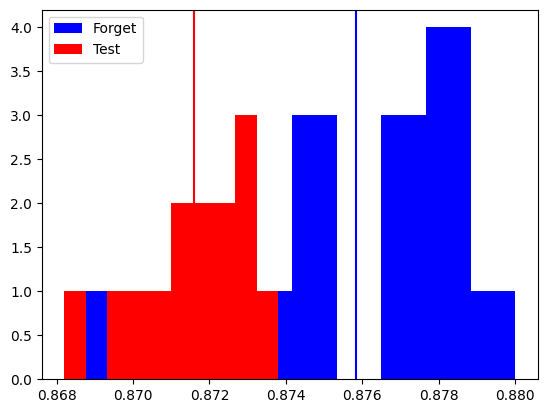

In [ ]:
plt.hist(forget_accs, color='blue', label='Forget')
plt.axvline(x=np.mean(forget_accs), color='blue')
plt.hist(test_accs, color='red', label='Test')
plt.axvline(x=np.mean(test_accs), color='red')
plt.legend()
plt.show()

### KL

In [ ]:
kl_losses = []
epsilon = 1e-2

for idx, original_loss in enumerate(original_losses):
    # losses_from_scratch = np.log(np.array(original_loss)/2 + epsilon)
    # losses_unlearn = np.log(np.array(unlearn_losses[idx]) + epsilon)

    # losses_from_scratch = np.random.lognormal(mean=losses_from_scratch.mean(), sigma=losses_from_scratch.std(), size=1000)
    # losses_unlearn = np.random.lognormal(mean=losses_unlearn.mean(), sigma=losses_unlearn.std(), size=1000)

    losses_from_scratch = np.array(original_loss)
    # losses_unlearn = np.array(unlearn_losses[idx])
    losses_unlearn = random.sample(unlearn_losses[idx], len(losses_from_scratch))

    # Ensure all losses are non-negative (they should naturally be if they are losses)
    # assert np.all(losses_from_scratch >= 0) and np.all(losses_unlearn >= 0), "Losses must be non-negative"

    # Normalize the losses to sum to one to represent probability distributions
    prob_dist_scratch = losses_from_scratch / np.sum(losses_from_scratch)
    prob_dist_unlearn = losses_unlearn / np.sum(losses_unlearn)

    # Compute the KL divergence (ensure no zero probability to avoid infinity)
    # Add a small constant to avoid division by zero or log of zero

    prob_dist_scratch += epsilon
    prob_dist_unlearn += epsilon

    # Normalize again after adding epsilon to ensure they sum to one
    prob_dist_scratch /= np.sum(prob_dist_scratch)
    prob_dist_unlearn /= np.sum(prob_dist_unlearn)

    # Calculate the KL divergence from scratch to unlearn
    kl_divergence = kl_div(prob_dist_scratch, prob_dist_unlearn)

    # Sum over all elements to get the total divergence
    total_kl_divergence = np.sum(kl_divergence)

    kl_losses.append(total_kl_divergence)

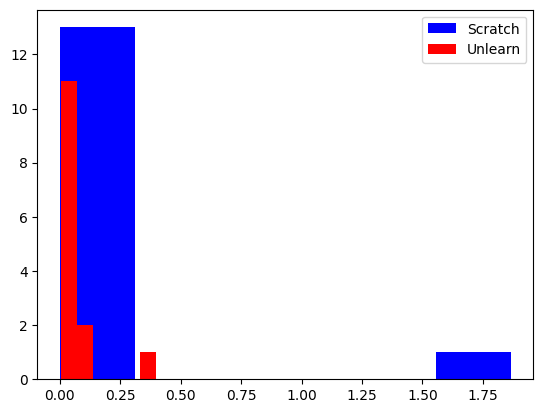

In [ ]:
plt.hist(original_losses[2], bins=6, color='blue', label='Scratch')
plt.hist(unlearn_losses[2], bins=6, color='red', label='Unlearn')
# plt.xscale('log')
plt.legend()
plt.show()

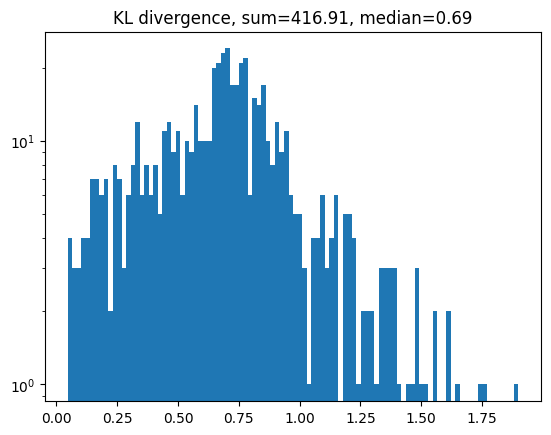

In [ ]:
plt.hist(kl_losses, bins=100, log=True)
plt.title(f'KL divergence, sum={np.sum(kl_losses):.2f}, median={np.median(kl_losses):.2f}')
plt.show()

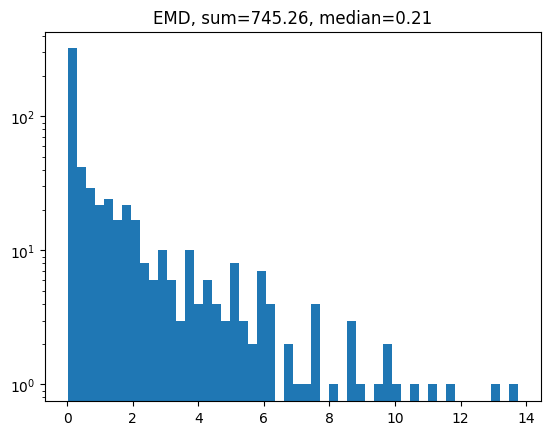

In [ ]:
# Normalize losses, calculate standard deviation, and EMD per sample
emd_scores = []

for idx, original_loss in enumerate(original_losses):
    # normalized_losses = [ul / original_loss for ul in unlearn_losses[idx]]
    # std_dev = np.std(normalized_losses)
    
    # # Create a normal distribution for the original loss with the unlearned std deviation
    # original_distribution = np.random.lognormal(loc=original_loss, scale=std_dev, size=100)
   
    # # Use the normalized losses as the distribution of the unlearned model
    # unlearn_distribution = normalized_losses
   
    # Calculate Earth Mover's Distance
    emd_score = wasserstein_distance(original_loss, unlearn_losses[idx])
    emd_scores.append(emd_score)

plt.hist(emd_scores, bins=50, log=True)
plt.title(f'EMD, sum={np.sum(emd_scores):.2f}, median={np.median(emd_scores):.2f}');

In [ ]:
# j = 0
# plt.hist(losses_from_scratch, color='blue', label='Trained from scratch')
# plt.axvline(x=np.mean(losses_from_scratch), color='blue')
# plt.hist(losses_unlearn, color='red', label='Unlearn')
# plt.axvline(x=np.mean(losses_unlearn), color='red')
# plt.yscale('log')
# plt.legend()
# plt.show()